In [168]:
import pandas as pd
import json
import numpy as np
import pymysql
import datetime
import time
import os
import h5py
import math
import glob
import matplotlib.pyplot as plt
from obspy.clients.iris import Client
from tqdm import tqdm
from scipy.signal import butter, filtfilt
from scipy import integrate
from scipy.signal import sosfilt, iirfilter, zpk2sos

In [169]:
%run utils.ipynb

In [170]:
def check_valid(wavefile):
    sql = 'SELECT d.label, d.s_time_available\
            FROM Event_Station_Data_new d \
            WHERE d.wave_file=\'' + str(wavefile) + '\';'
    cursor.execute(sql)
    results = cursor.fetchall()
    
    if results[-1] == 0:
        if '1' in results[0]:
            return '1'
        else:
            return '0'
        
    label = results[0][0].split(',')

    # label 個數為偶數次，取最後 label 結果為最終結果
    zero = label.count('0')
    one = label.count('1')

    if zero > one:
        return '0'
    else:
        return '1'

In [177]:
def parse_file(p, s, h5path, number_of_event, station_list, sensor, usage, record_inst):
    all_df = pd.DataFrame()
    df = pd.DataFrame()
    
    client = Client()
    
    hf = h5py.File(h5path, 'a')
    
    # source attributes
    df['source_origin_time'] = [p['ori_time']]
    df['source_depth_km'] = [p['depth']]
    df['source_latitude_deg'] = [p['lat']]
    df['source_longitude_deg'] = [p['lon']]
    df['source_magnitude'] = [p['mag']]
    df['source_magnitude_type'] = ['ml']    # 芮氏規模
    df['source_gap_deg'] = [p['gap']]
    
#     for k in tqdm(p.keys(), total=len(list(p.keys()))):
    for k in p.keys():
        try:
            if 'distance' in p[k].keys():
                n_data = p[k]['numberOfData']
                
                for n in range(n_data):
                    instrument = p[k][str(n)]['instrument']
                    status = check_valid(p[k][str(n)]['waveFile'])
                    
                    df['station_code'] = [k]
                    
                    # 新格式的 network = TW
                    df['station_network_code'] = ['TW']
                    
                    # 新格式的 location = 10, 00, 20
                    df['station_location_code'] = [convert_to_new_location(p[k][str(n)]['location'])]
                    df['station_p_polar'] = p[k]['p_polar']
                    
                    # 特別標示出這個 trace 有多個地震事件
                    df['trace_event_number'] = [number_of_event]
                    df['trace_channel'] = [convert_instrument_to_channel(instrument)]
                    
                    df['trace_start_time'] = [p[k][str(n)]['starttime']]
                    
                    factor, lon, lat, ele = get_factor(k, instrument, p[k][str(n)]['network'], p[k][str(n)]['location'], 
                                                       p[k][str(n)]['starttime'], s, station_list, sensor, usage, record_inst)
                    
                    df['trace_factor_ZNE'], df['station_longitude_deg'], df['station_latitude_deg'], df['station_elevation_m'] = [factor], [lon], [lat], [ele]
                    
                    # 若有多的事件在同個波型，則對應到相同的 trace
                    df['trace_name'] = [p['event'][:-1] + '_' + k + '_' + df['trace_channel'].iloc[0] + '_' + \
                                        p[k][str(n)]['network'] + '_' + df['station_location_code'].iloc[0]]
                    
                    sampling_rate = p[k][str(n)]['sampling_rate']
                    df['trace_sampling_rate_hz'] = [sampling_rate]
                    
                    df['trace_npts'] = [time_diff_sample(p[k][str(n)]['starttime'], p[k][str(n)]['endtime'], sampling_rate)]
                    df['trace_p_arrival_sample'] = [time_diff_sample(p[k][str(n)]['starttime'], p[k][str(n)]['p_arrival_time'], sampling_rate)]
                    df['trace_p_status'] = ['maunal']

                    if p[k][str(n)]['DataAvailable']['Stime']:
                        df['trace_s_arrival_sample'] = [time_diff_sample(p[k][str(n)]['starttime'], p[k][str(n)]['s_arrival_time'], sampling_rate)]
                        df['path_p_travel_s'] = [(df['trace_s_arrival_sample'].iloc[0]-df['trace_p_arrival_sample'].iloc[0]) / sampling_rate ]
                        df['trace_s_status'] = ['maunal']
                        df['trace_s_weight'] = [p[k]['s_weight']]
                    else:
                        df['trace_s_arrival_sample'] = [None]
                        df['trace_s_status'] = [None]
                        df['path_p_travel_s'] = [None]
                        df['trace_s_weight'] = [None]
                    
                    df['trace_p_weight'] = [p[k]['p_weight']]
                  
                    df['path_ep_distance_km'] = [p[k]['distance']]
                    df['path_p_residual_s'] = [p[k]['p_residual']]
                    df['path_s_residual_s'] = [p[k]['s_residual']]
                    df['path_back_azimuth_deg'] = [client.distaz(stalat=df['station_latitude_deg'].iloc[0], stalon=df['station_longitude_deg'].iloc[0], 
                                                                evtlat=df['source_latitude_deg'].iloc[0], evtlon=df['source_longitude_deg'].iloc[0])['backazimuth']]
                    
                    if df['path_p_travel_s'].iloc[0]  > 0:
                        df['trace_category'] = ['earthquake']
                    
                    if status == '1':
                        df['trace_completeness'] = [1]
                        wave_z, wave_n, wave_e = readWave('/mnt/nas2/CWBSN_modify_time/'+p[k][str(n)]['waveFile'])
                        
                        df['trace_snr_db'] = [round(snr_in_db(wave_z, wave_n, wave_e, df['trace_p_arrival_sample'].iloc[0]), 3)]
                        df['trace_Z_snr_db'] = [round(Zsnr_in_db(wave_z, df['trace_p_arrival_sample'].iloc[0]), 3)]
                    
                        pga, pga_g, z_pga = calc_pga(wave_z, wave_n, wave_e, sampling_rate, instrument)
                        pgv, z_pgv = calc_pgv(wave_z, wave_n, wave_e, sampling_rate, instrument)
      
                        df['trace_pga_perg'] = [round(pga_g, 3)]
                        df['trace_pga_cmps2'] = [round(pga, 3)]
                        df['trace_Z_pga_cmps2'] = [round(z_pga, 3)]
                        df['trace_pgv_cmps'] = [round(pgv, 3)]
                        df['trace_Z_pgv_cmps'] = [round(z_pgv, 3)]
                        
                        # write trace into hdf5 file: (3, npts)
                        wave = np.vstack((wave_z, wave_n, wave_e))
                       
                        hf.create_dataset('data/'+df['trace_name'].iloc[0], wave.shape, data=wave)
                    else:
                        df['trace_completeness'] = [0]
                    
                    all_df = pd.concat([all_df, df])
                    
        except Exception as exx:
#             print(exx)
            pass
        
    return all_df

In [178]:
def getfile(base_dir, year):
    files = glob.glob(base_dir+year+'/*.json')
    
    return files

### Start 

In [180]:
base_dir = "/mnt/nas2/CWBSN_modify_time/"
# year = [str(y) for y in range(2012, 2013)]
year = ['2020']
s = get_StationInfo()
station_list = pd.read_excel("/mnt/nas4/weiwei/seisbench_CWBSN/Station.xlsx")
sensor = pd.read_excel("/mnt/nas4/weiwei/seisbench_CWBSN/Sensor.xlsx")
usage = pd.read_excel("/mnt/nas4/weiwei/seisbench_CWBSN/Usage.xlsx")
record_inst = 'CWBSN'

db_setting = {
    'host': '127.0.0.1', 
    'port': 3300,
    'user': 'root',
    'password': 'earthquake_123456',
    'database': 'earthquake',
    'passwd': 'earthquake_123456',
    "charset": "utf8"
}
db = pymysql.connect(**db_setting)
cursor = db.cursor()

format = {
    'dimension_order': 'CW',
    'component_order': 'ZNE',
    'sampling_rate': 100,
    'unit': 'cmps/cmps2',
    'measurement': 'velocity/acceleration'
}

if not os.path.exists("/mnt/nas2/CWBSN_modify_time/seisbench"):
    os.makedirs("/mnt/nas2/CWBSN_modify_time/seisbench")

In [ ]:
for y in year:
    df = pd.DataFrame()
    print('year: ', y)
    
    files = getfile(base_dir, y)
    
    for f in tqdm(files, total=len(files)):
        number_of_event = check_multiple_event(f)
        
        json_file = open(f)
        p = json.load(json_file)
        
        json_df = parse_file(p, s, '/mnt/nas2/CWBSN_modify_time/seisbench/chunks_' + y + '.hdf5', number_of_event,
                            station_list, sensor, usage, record_inst)
            
        df = pd.concat([df, json_df])
        
    # write into files: metadata
    df.to_csv('/mnt/nas2/CWBSN_modify_time/seisbench/metadata_' + y + '.csv')
    
    # write into hdf5: chunks/data_format
    hf = h5py.File('/mnt/nas2/CWBSN_modify_time/seisbench/chunks_' + y + '.hdf5', 'a')
    for k, v in format.items():
        hf.create_dataset('data_format/'+k, data=v)


year:  2020


  0%|                                                                                                                                                                    | 0/509 [00:00<?, ?it/s]

In [ ]:
f = h5py.File("/mnt/nas2/CWBSN_modify_time/seisbench/chunks_2019.hdf5", 'r')
f.keys()

In [59]:
a = list(f['data'].keys())
len(a)

In [68]:
from obspy import Trace
from obspy.signal.trigger import z_detect, plot_trigger, classic_sta_lta, trigger_onset
import numpy as np
import torch
import os
import matplotlib.pyplot as plt

In [98]:
files = os.listdir('/mnt/nas3/earthquake_dataset_large/CWBSN/')
wave = torch.load('/mnt/nas3/earthquake_dataset_large/CWBSN/'+files[8977]).numpy()

In [99]:
trace = Trace(data=wave[0])
cft = z_detect(trace.data, 100*2)

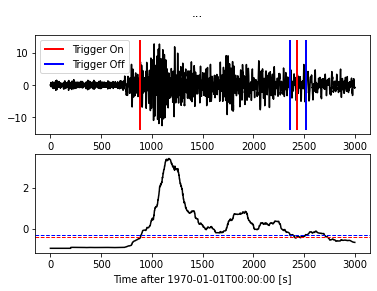

In [100]:
plot_trigger(trace, cft, -0.4, -0.3)

In [87]:
on_off = np.array(trigger_onset(cft, -0.4, -0.3))

In [91]:
on_off[:, 0].shape

(1,)